# HR-аналитика

# Описание проекта. 

В данном проекте по HR-аналитике необходимо предложить заказчику, как избежать финансовых потерь и оттока сотрудников. Было поставлено 2 задачи:
1) Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, тк удовлетворённость работой напрямую влияет на отток сотрудников. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

2) Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Заказчиком предоставлены данные по сотрудникам, содержащие такие параметры, как: отдел, уровень должности сотрудника, загруженность, количество лет в компании, зарплата, оценка качества работы, было ли повышение за последний год, нарушался ли трудовой договор за последний год, уровень удовлетворенности работой, ушел/остался в компании.

В рамках проекта проделаны следующие этапы:
- загрузка данных
- предобработка данных 
- исследовательский анализ данных
- обучение моделей
- сделан общий вывод и даны рекомендации заказчику


In [7]:
!pip install numpy==1.26.4
!pip install matplotlib==3.7.3
!pip install phik
!pip install -q --upgrade scikit_learn
!pip install shap

In [9]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
#import phik
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
#import shap
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import numpy as np
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif, mutual_info_classif  
from phik import phik_matrix
#from phik.report import plot_correlation_matrix
from sklearn.dummy import DummyClassifier
import sklearn
print(sklearn.__version__)
#проверка версии sklearn

1.6.1


In [10]:
warnings.filterwarnings('ignore')

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [11]:
try:
    train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
except:
    train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    test = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
test.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [6]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


### Предобработка данных

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [8]:
train.duplicated().sum()

0

In [9]:
train['id'].duplicated().sum()

0

In [10]:
train['dept'].value_counts()

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

In [11]:
train['workload'].value_counts()

medium    2066
low       1200
high       734
Name: workload, dtype: int64

In [12]:
train['employment_years'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [13]:
train['last_year_promo'].value_counts()

no     3880
yes     120
Name: last_year_promo, dtype: int64

In [14]:
train['last_year_violations'].value_counts()

no     3441
yes     559
Name: last_year_violations, dtype: int64

In [15]:
train['supervisor_evaluation'].sort_values().unique()

array([1, 2, 3, 4, 5])

In [16]:
train['level'].value_counts()

junior    1894
middle    1744
sinior     358
Name: level, dtype: int64

In [12]:
train.loc[train['level'] == 'sinior', 'level'] ='senior'

In [18]:
train['level'].value_counts()

junior    1894
middle    1744
senior     358
Name: level, dtype: int64

В датасете 'train' все названия столбцов в змеином регистре, пропуски есть в столбцах dept и level.
Явных или неявных дубликатов не выявлено.

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


В датасете 'test' все названия столбцов в змеином регистре, пропусков, явных или неявных дубликатов не выявлено.

In [20]:
test.duplicated().sum()

0

In [21]:
test['id'].duplicated().sum()

0

In [22]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [23]:
test_features.duplicated().sum()

0

In [24]:
test_features['id'].duplicated().sum()

0

In [25]:
test_features['dept'].value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

In [26]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [27]:
test_features['dept'].value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

In [28]:
test_features['level'].value_counts()

junior    974
middle    854
sinior    171
Name: level, dtype: int64

In [13]:
test_features.loc[test_features['level'] == 'sinior', 'level'] ='senior'
test_features['level'].value_counts()

junior    974
middle    854
senior    171
Name: level, dtype: int64

In [30]:
test_features['workload'].value_counts()

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

In [31]:
test_features['last_year_promo'].value_counts()

no     1937
yes      63
Name: last_year_promo, dtype: int64

In [32]:
test_features['last_year_violations'].value_counts()

no     1738
yes     262
Name: last_year_violations, dtype: int64

In [33]:
test_features['supervisor_evaluation'].sort_values().unique()

array([1, 2, 3, 4, 5])

В датасете 'test_features' все названия столбцов в змеином регистре, пропуски есть в столбцах dept и level, также в столбцах dept и workload выявлено по одному пробелу. Явных или неявных дубликатов не выявлено. Заполним пробелы и пропуски в пайплайне.

In [14]:
si1_columns = ['dept', 'level', 'workload']
si2_columns = ['dept', 'workload']
si_pipe = Pipeline([('si1',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                    ('si2', SimpleImputer(missing_values=' ', strategy='most_frequent'))])

In [15]:
data_preprocessor = ColumnTransformer(
    [('si1', si_pipe, si1_columns),
     ('si2', si_pipe, si2_columns),   ], 
    remainder='passthrough'
)

In [16]:
train_si = pd.DataFrame(
    data_preprocessor.fit_transform(train[['dept', 'level', 'workload']]),
    columns=data_preprocessor.get_feature_names_out()    
) 
train_si.head()

,si1__dept,si1__level,si1__workload,si2__dept,si2__workload
0,sales,junior,medium,sales,medium
1,hr,junior,high,hr,high
2,sales,junior,low,sales,low
3,technology,junior,low,technology,low
4,hr,junior,medium,hr,medium


In [17]:
train['dept'] = train_si['si1__dept']
train['workload'] = train_si['si1__workload']
train['level'] = train_si['si1__level']
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [18]:
test_features_si = pd.DataFrame(
    data_preprocessor.transform(test_features[['dept', 'level', 'workload']]),
    columns=data_preprocessor.get_feature_names_out()    
) 
test_features_si.head()

,si1__dept,si1__level,si1__workload,si2__dept,si2__workload
0,marketing,junior,medium,marketing,medium
1,hr,junior,medium,hr,medium
2,sales,middle,low,sales,low
3,sales,middle,low,sales,low
4,hr,middle,medium,hr,medium


In [19]:
test_features['dept'] = test_features_si['si1__dept']
test_features['workload'] = test_features_si['si1__workload']
test_features['level'] = test_features_si['si1__level']
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [40]:
test_features['dept'].value_counts()

sales         766
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64

In [41]:
test_features['workload'].value_counts()

medium    1044
low        593
high       363
Name: workload, dtype: int64

По итогам предобработки данных были выявлены пропуски в датасетах train_job_satisfaction_rate и test_ - во входных признаках 'dept' и 'level', а также в датасете test_features - пробелы в признаках 'dept' и 'workload'. Оба ви пропускв были заполнены в паплайнах. Явных или неявных дубликатов вывлено не было.

### Исследовательский анализ данных

In [42]:
train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [43]:
test.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


In [44]:
test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


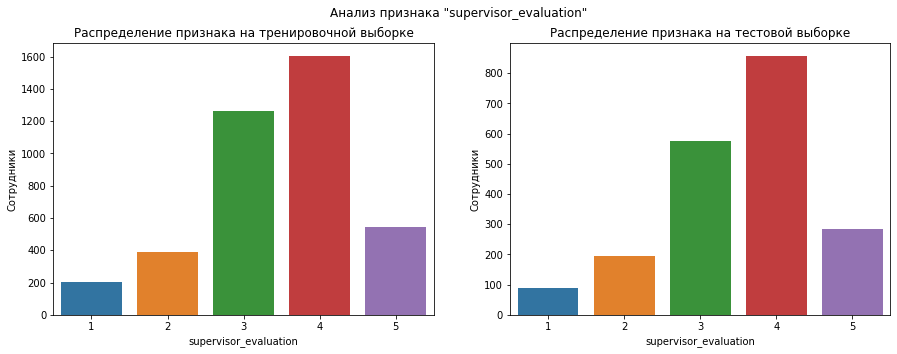

In [45]:
def cpl(df_1, df_2, label):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    fig.suptitle(f'Анализ признака "{df_1.name}"')
    plt.subplot(1, 2, 1)
    sns.countplot(df_1);
    plt.ylabel(label);
    plt.title('Распределение признака на тренировочной выборке');
    plt.subplot(1, 2, 2)
    sns.countplot(df_2);
    plt.title('Распределение признака на тестовой выборке');
    plt.ylabel(label);
    
cpl(train['supervisor_evaluation'], test_features['supervisor_evaluation'], 'Сотрудники')


Средний балл 3,5 на обоих выборках, чаще всего сотрудникам ставили оценки "3" и "4".

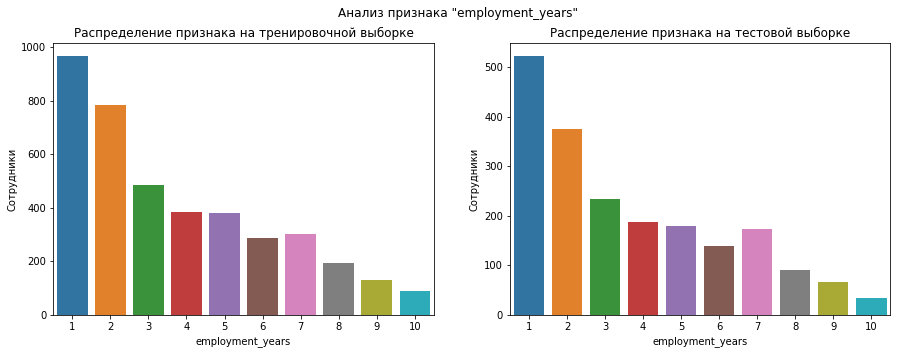

In [46]:
cpl(train['employment_years'], test_features['employment_years'], 'Сотрудники')


Больше всего сотудников проработало в компании 1 или 2 года.

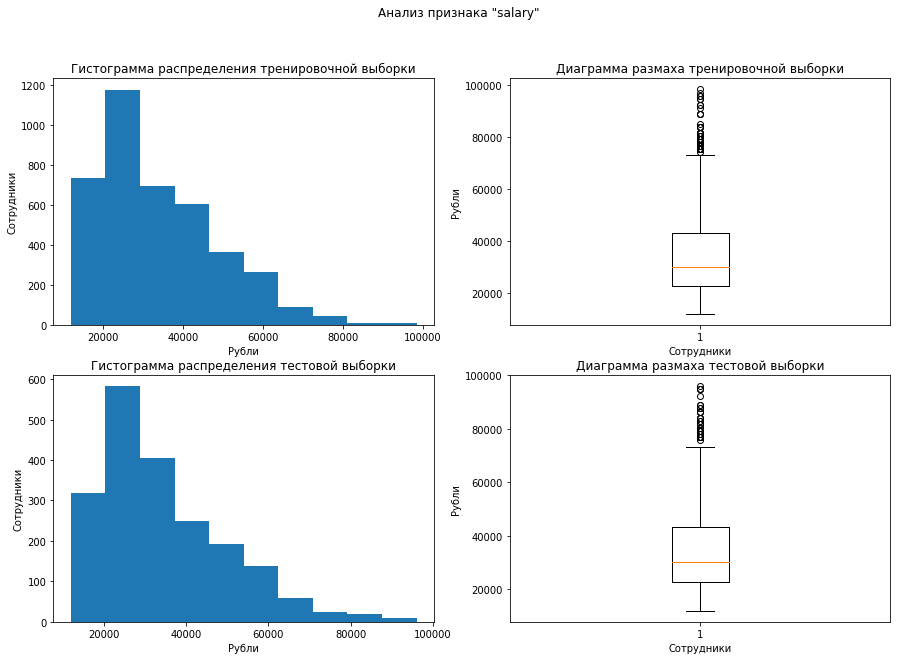

In [47]:
def stat(df_1, df_2, label):
  #  figsize=(25, 25)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    fig.suptitle(f'Анализ признака "{df_1.name}"')
    axes[0,0].hist(df_1);
    axes[0,0].set_xlabel(label);
    axes[0,0].set_ylabel('Сотрудники');
    axes[0,0].set_title('Гистограмма распределения тренировочной выборки');
    axes[0,1].boxplot(df_1);
    axes[0,1].set_title('Диаграмма размаха тренировочной выборки');
    axes[0,1].set_xlabel('Сотрудники');
    axes[0,1].set_ylabel(label);
    axes[1,0].hist(df_2);
    axes[1,0].set_xlabel(label);
    axes[1,0].set_ylabel('Сотрудники');
    axes[1,0].set_title('Гистограмма распределения тестовой выборки');
    axes[1,1].boxplot(df_2);
    axes[1,1].set_title('Диаграмма размаха тестовой выборки');
    axes[1,1].set_xlabel('Сотрудники');
    axes[1,1].set_ylabel(label);
stat(train['salary'], test_features['salary'], 'Рубли')

Средняя зарплата сотрудников - около 34,000, медианная - 30,000. Минимум - 12,000, мксимум - 98,000, присутствует много выбросов в бОльшую сторону.

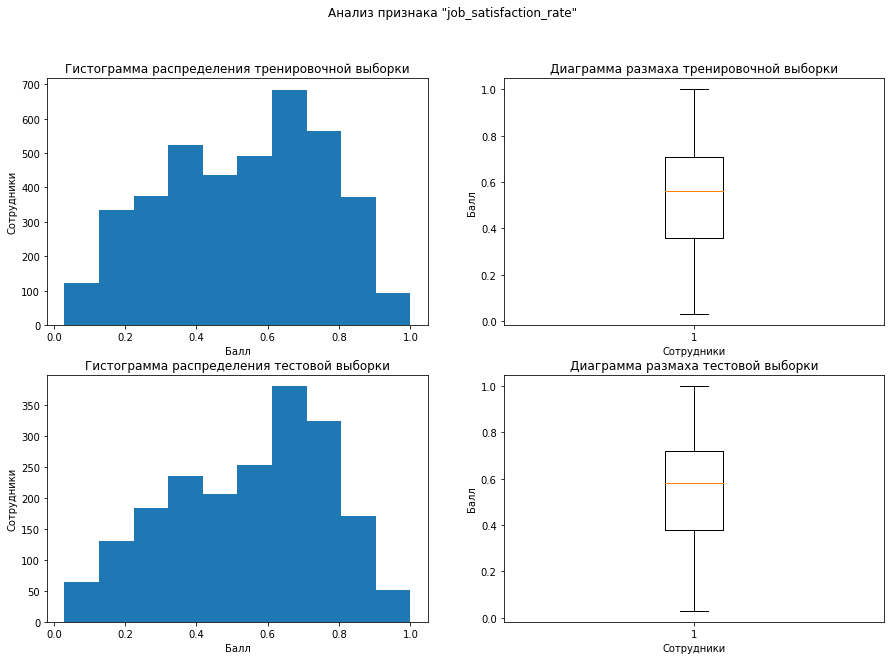

In [48]:
stat(train['job_satisfaction_rate'], test['job_satisfaction_rate'], 'Балл')

Средний уровень удовлетворенности сотрудников - около 0,51-0,53, выбросов нет.

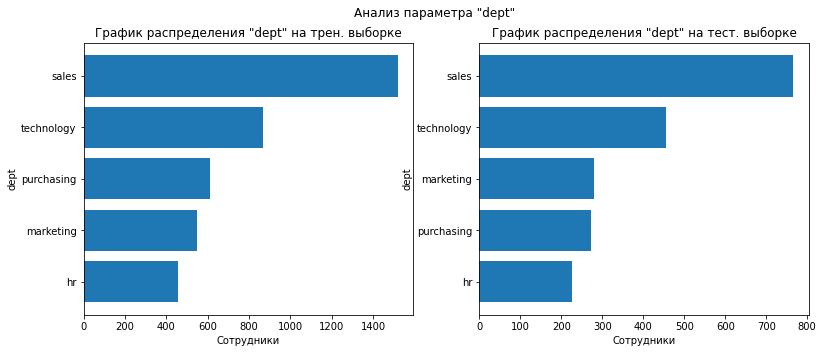

In [49]:
def pl(df_1, df_2, index):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
    fig.suptitle(f'Анализ параметра "{index}"')
    plt.subplot(1, 2, 1)
    plt.title(f'График распределения "{index}" на трен. выборке');
    df1=df_1.pivot_table(index=index, values='id', aggfunc='count').sort_values(by='id',ascending=True)
    df1= pd.DataFrame(df1.to_records())
    x=df1[index]
    y=df1['id']
    plt.barh(x, y)
    plt.xlabel('Сотрудники');
    plt.ylabel(index);
    plt.subplot(1, 2, 2)
    plt.title(f'График распределения "{index}" на тест. выборке');
    df2=df_2.pivot_table(index=index, values='id', aggfunc='count').sort_values(by='id',ascending=True) 
    df2= pd.DataFrame(df2.to_records())
    x=df2[index]
    y=df2['id'].unique()
    plt.barh(x, y)
    plt.xlabel('Сотрудники');
    plt.ylabel(index);
pl(train, test_features, 'dept')   

Больше всего сотрудников работает в отделе Sales, затем следуют Technology, потом Purchasing, Marketing и меньше всего в HR.

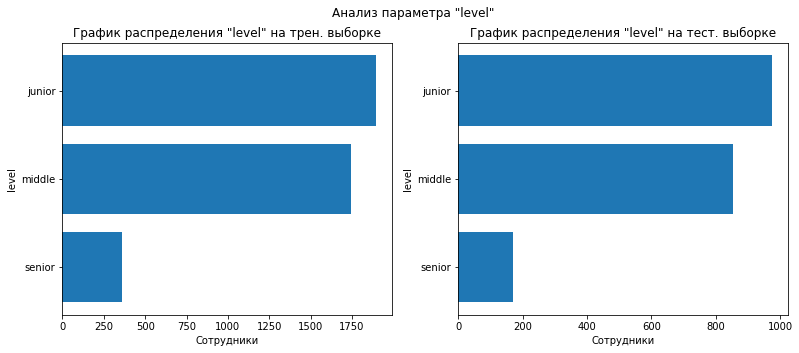

In [50]:
pl(train, test_features, 'level')   

Больше всего сотрудников уровня  "junior", чуть меньше "middle" и меньшинство "" sinior.

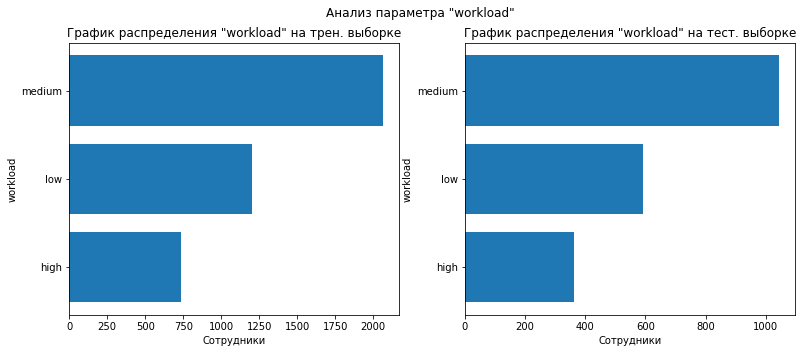

In [51]:
pl(train, test_features, 'workload')   

Большинство сотрудников имеет средний уровень загруженности.

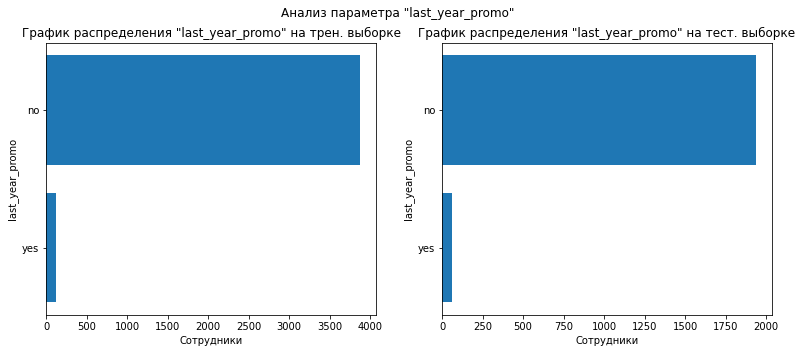

In [52]:
pl(train, test_features, 'last_year_promo')   

Очень малая доля сотрудников получила промоушен в прошлом году.

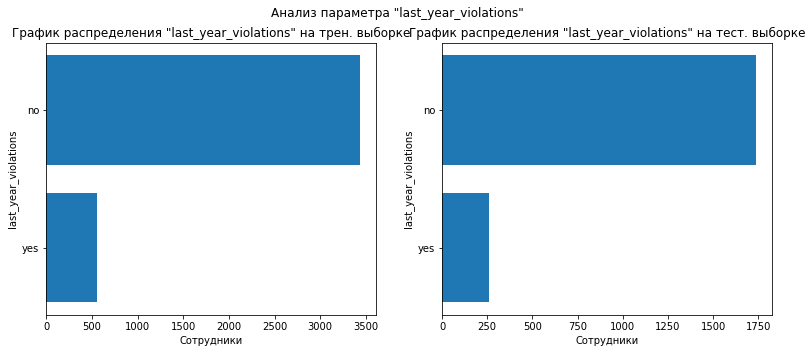

In [53]:
pl(train, test_features, 'last_year_violations')   

Около 750 сотрудников в общей сложности нарушили договор в прошлом году.

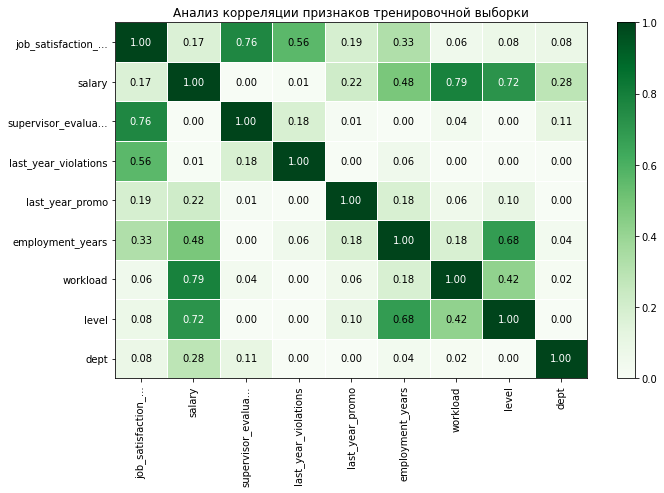

In [54]:
df= train.loc[: , train.columns != 'id']
df= df.loc[: , df.columns != 'index']
interval_columns=['salary','job_satisfaction_rate']
phik_overview = phik_matrix(df, interval_cols=interval_columns)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.0,
    figsize=(10, 7)
) 

plt.title('Анализ корреляции признаков тренировочной выборки');

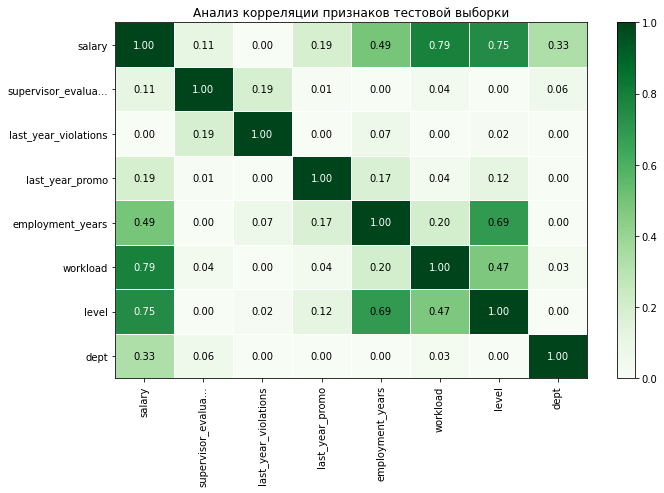

In [55]:
df= test_features.loc[: , test_features.columns != 'id']
df= df.loc[: , df.columns != 'index']
interval_columns=['salary','job_satisfaction_rate']
phik_overview = phik_matrix(df, interval_cols=interval_columns)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.0,
    figsize=(10, 7)
) 
plt.title('Анализ корреляции признаков тестовой выборки');

Для обеих выборок мультиколлинеарность (значение коэффициента корреляции более 0.9 по модулю) между признаками не наблюдается.
На тренировочной выборке можно отметить высокий уровень корреляции между целевым признаком "job_satisfaction_rate" и входным признаком  "supervisor_evaluation", заметный уровень с "last_year_violations" и а также умереннуую корреляцию с "employment_years".
Также на обеих выборках можно отметить высокую корреляцию между  входными признаками "salary" и "workload", "salary" и "level" и умеренную между "salary" и "employment_years"; заметную между "level" и "employment_years"; умеренную - между "level" и "workload". 

По итогам исследовательского анализа данных можно сделать следующие выводы: 

- Средний балл 3,5 на обоих выборках, чаще всего сотрудникам ставили оценки "3" и "4".
- Больше всего сотудников проработало в компании 1 или 2 года.
- Средняя зарплата сотрудников - около 34,000, медианная - 30,000. Минимум - 12,000, мксимум - 98,000, присутствует много выбросов в бОльшую сторону.
- Средний уровень удовлетворенности сотрудников - около 0,52, выбросов нет.
- Больше всего сотрудников работает в отделе Sales, затем следуют Technology, Purchasing, Marketing и меньше всего в HR.
- Больше всего сотрудников имеют уровнь "junior", чуть меньше "middle" и меньшинство "sinior".
- Большинство сотрудников имеет средний уровень загруженности.
- Очень малая доля сотрудников получили промоушен в прошлом году.
- Около 750 сотрудников нарушили договор в прошлом году.
Мультиколлинеарность(значение коэффициента корреляции более 0.9 по модулю) между признаками не наблюдается.

### Подготовка данных

Используем пайплайны для кодирования категориальных и масштабирования количественных признаков.

In [20]:
RANDOM_STATE = 42

In [21]:
test_full=test_features.merge(test, on='id')

test_full

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,0.14
1997,305653,technology,junior,low,1,no,no,3,14400,0.11
1998,160233,technology,middle,low,8,no,no,1,32400,0.43


In [22]:
X_train = train.drop(['id'], axis=1)
X_train.duplicated().sum()

248

In [23]:
X_train= X_train.drop_duplicates()

In [24]:
X_train = train.drop(['job_satisfaction_rate','id'], axis=1)

In [25]:
y_train = train['job_satisfaction_rate']    
X_test = test_full.drop(['job_satisfaction_rate','id'], axis=1)
y_test = test_full['job_satisfaction_rate']

In [62]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   2000 non-null   object
 1   level                  2000 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


In [26]:
ohe_columns = ['dept']
num_columns=['employment_years', 'supervisor_evaluation', 'salary']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations', ]

In [27]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['yes', 'no']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ])



In [28]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )


In [29]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [30]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()    
) 
X_train_p.head()

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ord__level,ord__workload,ord__last_year_promo,ord__last_year_violations,num__employment_years,num__supervisor_evaluation,num__salary
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.675991,-2.455174,-0.666273
1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,-0.675991,1.510381,0.300245
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.069351,-1.463785,-1.471705
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.110731,-1.463785,-1.068989
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.069351,-0.472397,-0.746816


In [31]:
X_test_p.head()

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ord__level,ord__workload,ord__last_year_promo,ord__last_year_violations,num__employment_years,num__supervisor_evaluation,num__salary
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.675991,1.510381,-0.344101
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.069351,0.518992,-0.263557
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.504092,0.518992,-0.988446
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.897453,0.518992,-0.988446
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.504092,1.510381,0.461331


### Обучение моделей

Обучим следующие модели: LinearRegression(), DecisionTreeRegressor() и подберем для них гиперпараметры в пайплайнах.

In [32]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [33]:
param_distributions = [
    
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()], 
        
    },
   
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
 #       'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],  
       
    }
    
]

In [34]:
def smape(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2)) * 100


In [35]:
smape_score = make_scorer(
    smape,
    greater_is_better=False,
)

In [36]:
scoring = {
      'smape': smape_score
}

In [37]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring=scoring, 
    refit='smape',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [38]:
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
#print('Гиперпараметры', randomized_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', -round(randomized_search.best_score_,2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                    

In [76]:
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {round(smape(y_test, y_test_pred),2)}') 
y_test_pred

Метрика SMAPE на тестовой выборке: 13.64


array([0.8495    , 0.664     , 0.69181818, ..., 0.17      , 0.51857143,
       0.56571429])

In [77]:
model=DecisionTreeRegressor(max_depth=14, min_samples_leaf=5, min_samples_split=5, random_state=42)
model.fit(X_train_p, y_train)

DecisionTreeRegressor(max_depth=14, min_samples_leaf=5, min_samples_split=5,
                      random_state=42)

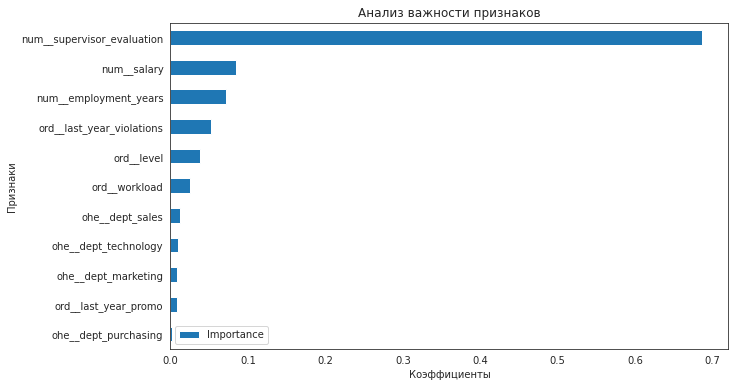

In [78]:
coefficients = model.feature_importances_
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': X_train_p.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)); 
plt.title('Анализ важности признаков');
plt.xlabel('Коэффициенты');
plt.ylabel('Признаки');

Лучшая модель: DecisionTreeRegressor(max_depth=14, min_samples_leaf=5, min_samples_split=5, random_state=42)
Метрика SMAPE лучшей модели на кросс-валидации: 14.89.
Метрика SMAPE лучшей модели на тестовой выборке: 13.64.
Самые важные признаки (в порядке убывания): supervisor_evaluation,  salary, employment_years, last_year_violations, level, workload, остальные признаки менее значимые.

### Промежуточные выводы

Лучшей моделью для решения данной задачи оказалось Дерево решений: DecisionTreeRegressor(max_depth=14, min_samples_leaf=5, min_samples_split=5, random_state=42)
Метрика SMAPE лучшей модели на кросс-валидации: 14.89
Метрика SMAPE лучшей модели на тестовой выборке: 13.64.
Модель DecisionTreeRegressor сработала лучше, чем LinearRegression(), видимо из-за того, что присутствуют  нелинейные зависимости между целевым и входными признаками.
Самые важные признаки (в порядке убывания): supervisor_evaluation,  salary, employment_years, last_year_violations, level, workload, остальные признаки менее значимые. Именно на данные параметры бизнесу следует обратить особое внимания для контроля целевого признака job_satisfaction_rate.

## Задача 2: предсказание увольнения сотрудника из компании


### Загрузка данных

In [79]:
try:
    train_1 = pd.read_csv('/datasets/train_quit.csv')
    test_1 = pd.read_csv('/datasets/test_target_quit.csv')
    test_features_1 = pd.read_csv('/datasets/test_features.csv')
except:
    train_1 = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    test_1 = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv.csv')
    test_features_1 = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
train_1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [80]:
test_1.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [81]:
test_features_1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


### Предобработка данных

In [82]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [83]:
train_1.duplicated().sum()

0

In [84]:
train_1['id'].duplicated().sum()

0

В датасете 'train_1' все названия столбцов в змеином регистре, пропуски есть в столбцах dept и level.
Явных или неявных дубликатов не выявлено.

In [85]:
train_1['dept'].value_counts()

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

In [86]:
train_1['workload'].value_counts()

medium    2118
low       1208
high       674
Name: workload, dtype: int64

In [87]:
train_1['employment_years'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [88]:
train_1['last_year_promo'].value_counts()

no     3887
yes     113
Name: last_year_promo, dtype: int64

In [89]:
train_1['last_year_violations'].value_counts()

no     3455
yes     545
Name: last_year_violations, dtype: int64

In [90]:
train_1['supervisor_evaluation'].sort_values().unique()

array([1, 2, 3, 4, 5])

In [91]:
train_1['level'].value_counts()

junior    1949
middle    1694
sinior     357
Name: level, dtype: int64

In [92]:
train_1.loc[train_1['level'] == 'sinior', 'level'] ='senior'
train_1['level'].value_counts()

junior    1949
middle    1694
senior     357
Name: level, dtype: int64

In [93]:
test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [94]:
test_1.duplicated().sum()

0

In [95]:
test_1['id'].duplicated().sum()

0

В датасете 'test_1' все названия столбцов в змеином регистре, пропусков, явных или неявных дубликатов не выявлено.

In [96]:
test_features_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [97]:
test_features_1.duplicated().sum()

0

In [98]:
test_features_1['id'].duplicated().sum()

0

In [99]:
test_features_1['dept'].value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

In [100]:
test_features_1['level'].value_counts()

junior    974
middle    854
sinior    171
Name: level, dtype: int64

In [101]:
test_features_1.loc[test_features_1['level'] == 'sinior', 'level'] ='senior'
test_features_1['level'].value_counts()

junior    974
middle    854
senior    171
Name: level, dtype: int64

In [102]:
test_features_1['workload'].value_counts()

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

В датасете 'test_features_1' все названия столбцов в змеином регистре, пропуски есть в столбцах dept и level, также в столбцах dept и workload выявлено по одному пробелу. Явных или неявных дубликатов не выявлено. Заполним пробелы и пропуски в пайплайне.

In [103]:
si1_columns = ['dept', 'level']
si2_columns = ['dept', 'workload']


In [104]:
si_pipe = Pipeline([('si1',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                ('si2', SimpleImputer(missing_values=' ', strategy='most_frequent'))])

In [105]:
data_preprocessor = ColumnTransformer(
    [('si1', si_pipe, si1_columns),
     ('si2', si_pipe, si2_columns),   ], 
    remainder='passthrough'
)

In [106]:
train_si = pd.DataFrame(
    data_preprocessor.fit_transform(train_1[['dept', 'level', 'workload']]),
    columns=data_preprocessor.get_feature_names_out()    
)
train_si.head()

,si1__dept,si1__level,si2__dept,si2__workload
0,sales,middle,sales,high
1,sales,junior,sales,medium
2,purchasing,middle,purchasing,medium
3,sales,junior,sales,medium
4,marketing,junior,marketing,medium


In [107]:
test_features_1_si = pd.DataFrame(
    data_preprocessor.transform(test_features_1[['dept', 'level', 'workload']]),
    columns=data_preprocessor.get_feature_names_out()    
) 
test_features_1_si.head()

,si1__dept,si1__level,si2__dept,si2__workload
0,marketing,junior,marketing,medium
1,hr,junior,hr,medium
2,sales,middle,sales,low
3,sales,middle,sales,low
4,hr,middle,hr,medium


In [108]:
test_features_1['dept'] = test_features_1_si['si2__dept']
test_features_1['workload'] = test_features_1_si['si2__workload']
test_features_1['level'] = test_features_1_si['si1__level']
test_features_1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [109]:
test_features_1['dept'].value_counts()

sales         766
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64

In [110]:
test_features_1['workload'].value_counts()

medium    1044
low        593
high       363
Name: workload, dtype: int64

In [111]:
test_features_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [112]:
test_1_full=test_features_1.merge(test_1, on='id')
test_1_full

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,yes
1996,109582,technology,middle,low,3,no,no,2,21600,yes
1997,305653,technology,junior,low,1,no,no,3,14400,yes
1998,160233,technology,middle,low,8,no,no,1,32400,no


In [113]:
test_features_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [114]:
test_features_1.duplicated().sum()

0

По итогам предобработки данных были выявлены пропуски в датасете test_features - во входных признаках 'dept' и 'level', а также пробелы в признаках 'dept' и 'workload'. Оба вида пропускв были заполнены в паплайнах. Явных или неявных дубликатов вывлено не было.

### Исследовательский анализ данных

Исследуем только тренировочную выборку, тк тестовая была уже исследована в первой задаче.

In [115]:
train_1.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


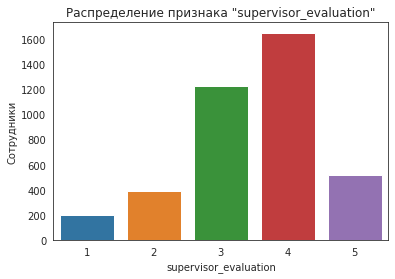

In [116]:
sns.countplot(train_1['supervisor_evaluation']);
plt.title('Распределение признака "supervisor_evaluation"');
plt.ylabel('Сотрудники');

Средний балл 3,5 на обоих выборках, чаще всего сотрудникам ставили оценки "3" и "4".

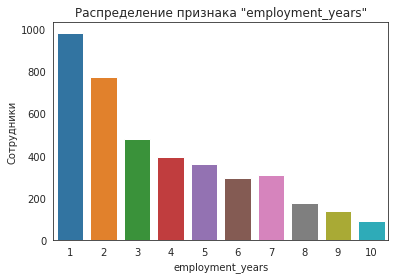

In [117]:
sns.countplot(train_1['employment_years']);
plt.title('Распределение признака "employment_years"');
plt.ylabel('Сотрудники');

Больше всего сотудников проработало в компании 1 или 2 года.

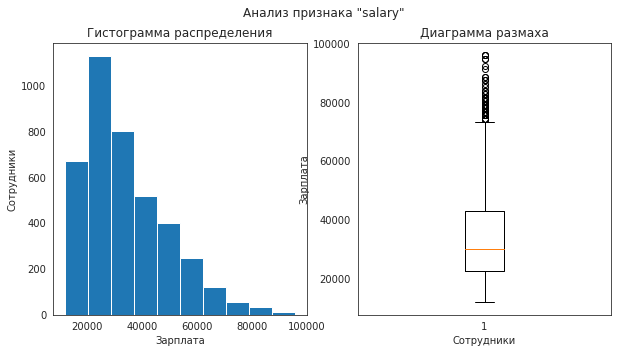

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle(f'Анализ признака "salary"')
axes[0].hist(train_1['salary']);
axes[0].set_xlabel('Зарплата');
axes[0].set_ylabel('Сотрудники');
axes[0].set_title('Гистограмма распределения');
axes[1].boxplot(train_1['salary']);
axes[1].set_title('Диаграмма размаха');
axes[1].set_xlabel('Сотрудники');
axes[1].set_ylabel('Зарплата');

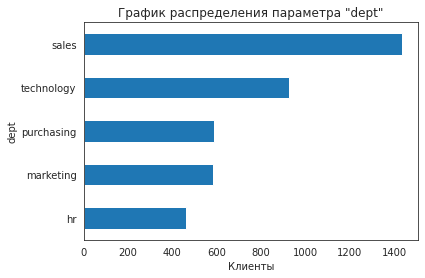

In [119]:
def pl_1(df, index):
    df.pivot_table(index=index, values='id', aggfunc='count').sort_values(by='id',ascending=True).plot(kind='barh', legend=False);
    plt.title(f'График распределения параметра "{index}"');
    plt.xlabel('Клиенты');
pl_1(train_1,'dept')    

Больше всего сотрудников работает в отделе Sales, затем следуют Technology, потом Purchasing, Marketing и меньше всего в HR.

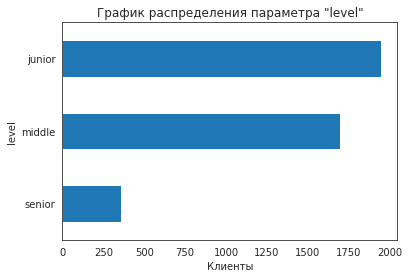

In [120]:
pl_1(train_1, 'level')   

Больше всего сотрудников уровня  "junior", чуть меньше "middle" и меньшинство "" sinior.

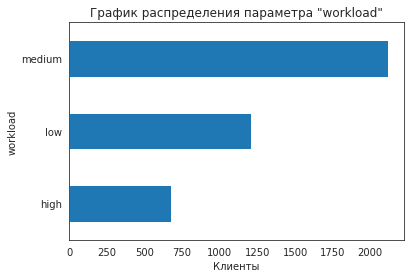

In [121]:
pl_1(train_1, 'workload')   

Большинство сотрудников имеет средний уровень загруженности.

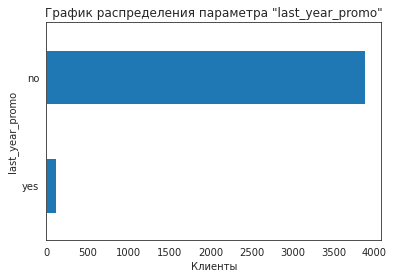

In [122]:
pl_1(train_1,'last_year_promo')   

Очень малая доля сотрудников получила промоушен в прошлом году.

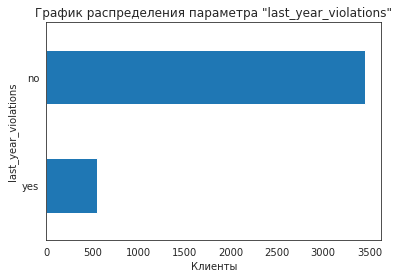

In [123]:
pl_1(train_1, 'last_year_violations')   

Около 500 сотрудников нарушили договор в прошлом году.

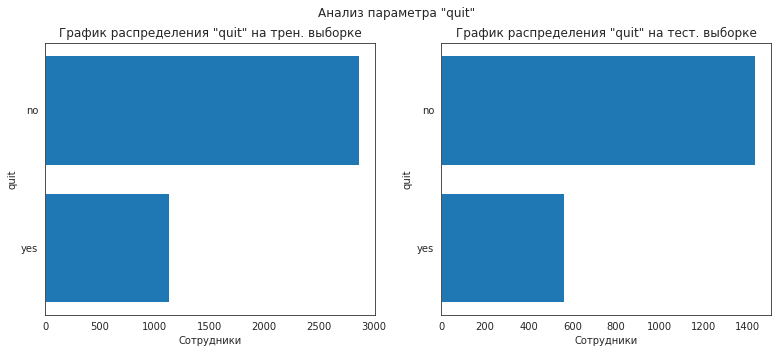

In [124]:
#pl_1(train_1, 'quit')   
pl(train_1, test_1, 'quit')   

Около трети всех сотрудников приняли решение покинуть компанию.

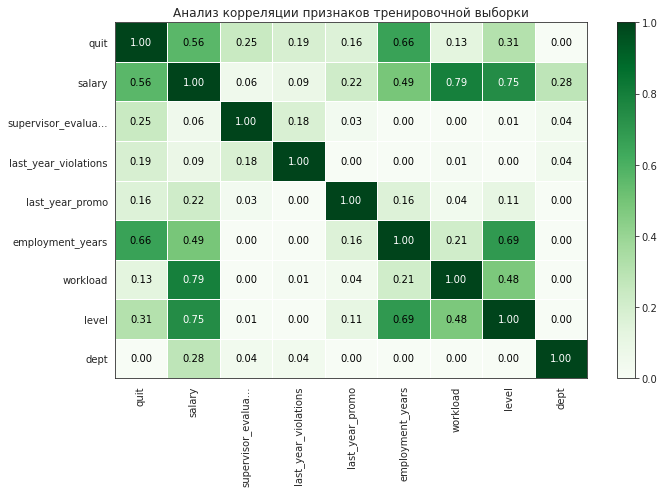

In [125]:
df= train_1.loc[: , train_1.columns != 'id']
df= df.loc[: , df.columns != 'index']
interval_columns=['salary']
phik_overview = phik_matrix(df, interval_cols=interval_columns)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.0,
    figsize=(10, 7)
) 
plt.title('Анализ корреляции признаков тренировочной выборки');

Мультиколлинеарность (значение коэффициента корреляции более 0.9 по модулю) между признаками не наблюдается.
Можно отметить заметный уровень корреляции между целевым признаком "quit" и входным признаком  "employment_years" и "salary", умеренный уровень с "workload".

Также на обеих выборках можно отметить высокую корреляцию между  входными признаками "salary" и "workload", "salary" и "level" и умеренную между "salary" и "employment_years"; заметную между "level" и "employment_years"; умеренную - между "level" и "workload". 

Исследуем портрет уволившегося сотрудника.

In [126]:
quit_1 = train_1.query('quit == "yes"')
quit_1.pivot_table(index='dept', values='id', aggfunc='count')
quit_1 = pd.DataFrame(quit_1.to_records())
labels = quit_1['dept'].unique()
labels

array(['sales', 'technology', 'marketing', 'purchasing', 'hr'],
      dtype=object)

In [127]:
no_quit_1 = train_1.query('quit == "no"')

In [128]:
def share(df, index):
    all_feature = df.pivot_table(index=index, values='id', aggfunc='count')
    all_feature= pd.DataFrame(all_feature.to_records())
    quit_feature = df.query('quit == "yes"').pivot_table(index=index, values='id', aggfunc='count')
    quit_feature= pd.DataFrame(quit_feature.to_records())
    quit_feature['percent']=quit_feature['id']/all_feature['id']    
    labels = quit_feature[index].unique()
    plt.bar(labels, quit_feature['percent'], label='share_quit');
    plt.title(f'Доли уволившихся сотрудников в каждом значении признака "{index}"'); 
    plt.ylabel('Доля');

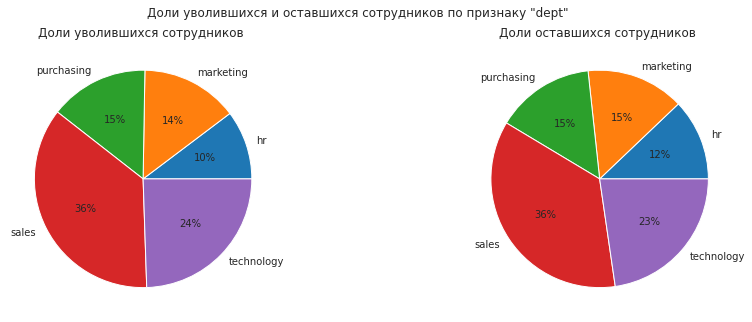

In [129]:
def pie(df, index):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
    fig.suptitle(f'Доли уволившихся и оставшихся сотрудников по признаку "{index}"') 
    quit_feature = df.query('quit == "yes"').pivot_table(index=index, values='id', aggfunc='count')
    quit_feature= pd.DataFrame(quit_feature.to_records())
    no_quit_feature = df.query('quit == "no"').pivot_table(index=index, values='id', aggfunc='count')
    no_quit_feature= pd.DataFrame(no_quit_feature.to_records())
    labels = quit_feature[index].unique()
   
    ax1.pie(quit_feature['id'], autopct='%.0f%%', labels=labels);
    ax1.set_title('Доли уволившихся сотрудников ');
    
    labels= no_quit_feature[index].unique()
    ax2.pie(no_quit_feature['id'], autopct='%.0f%%', labels=labels);
    ax2.set_title('Доли оставшихся сотрудников ');
        

pie(train_1, 'dept')

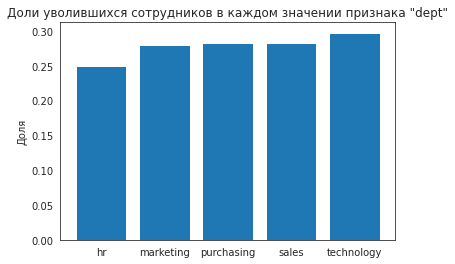

In [130]:
share(train_1, 'dept')   

Уволившиеся сотрудники чуть чаще увольнялись из отдела Technoloqy, примерно одинаково из отделов Sales и Purchasing и  Marketing и чуть реже из HR. Распределение уволившихся сотрудников по отделам в целом совпадает с распределением оставшихся сотрудников по отделам.

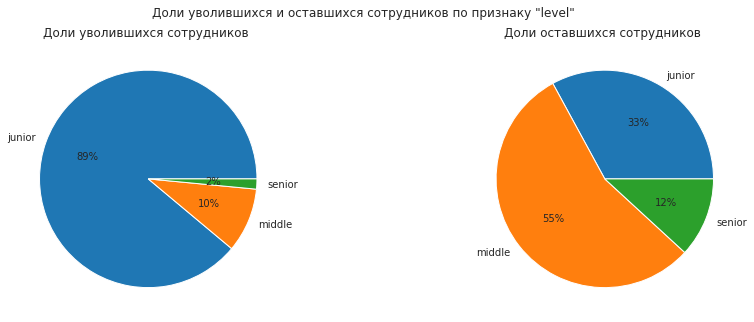

In [131]:
pie(train_1, 'level')

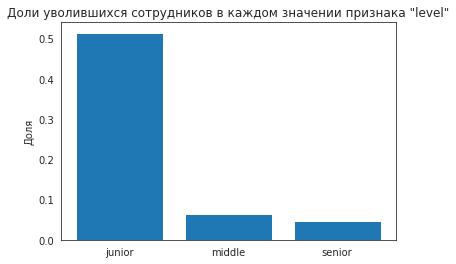

In [132]:
share(train_1, 'level')  

В основном у уволившихся сотрудников был уровень Junior, из таковых уволилось около 50%.

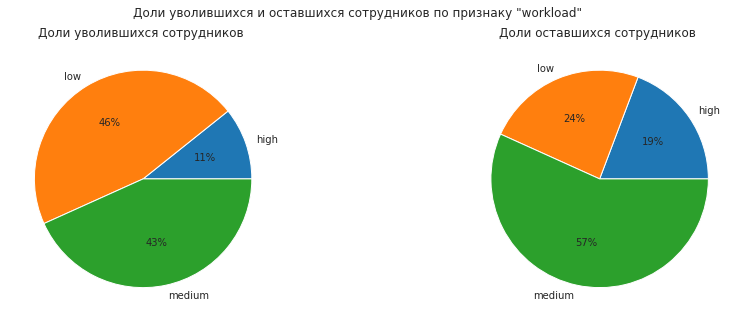

In [133]:
pie(train_1, 'workload')

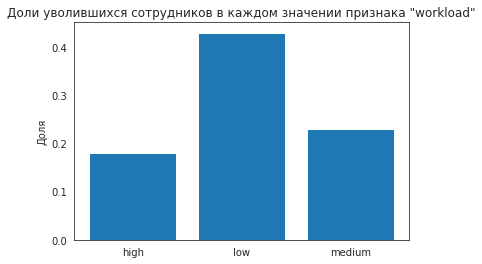

In [134]:
share(train_1, 'workload')  

У уволившихся сотрудников был низкий или средний уровень загруженности, наибольший % уволившихся среди сотрудников с низким уровнем загруженности.

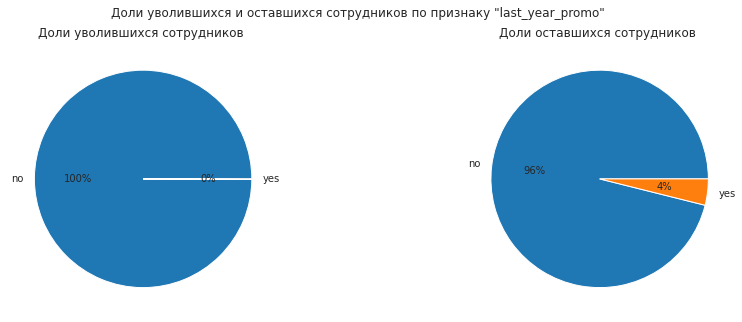

In [135]:
pie(train_1, 'last_year_promo')

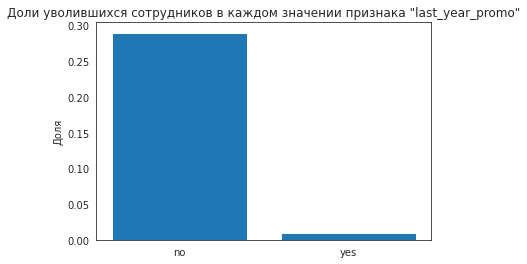

In [136]:
share(train_1, 'last_year_promo')  

Практически никто из уволившихся сотрудников не был промотирован в прошлом году. Их доля среди непромотированных гораздо больше, чем среди промотированных.

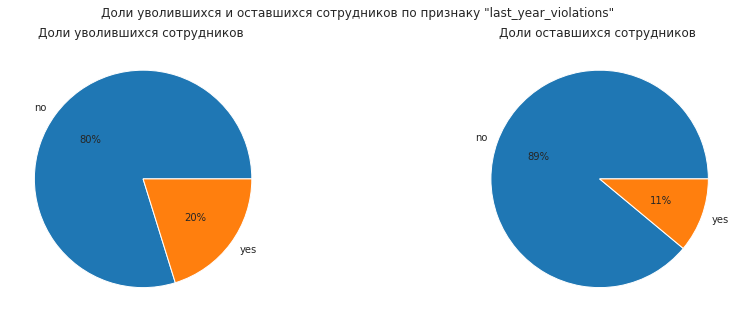

In [137]:
pie(train_1, 'last_year_violations')

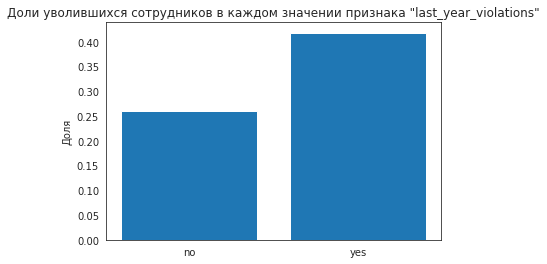

In [138]:
share(train_1, 'last_year_violations')  

У уволившихся сотрудников несколько большая доля last_year_violations по сравнению с оставшимися. Среди отличившихся доля уволившихся достигает 40%.

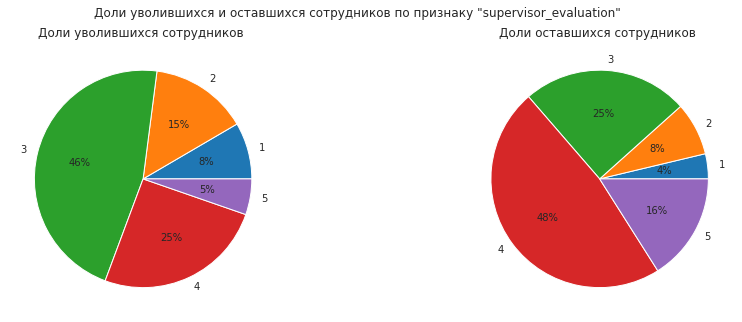

In [139]:
pie(train_1, 'supervisor_evaluation')

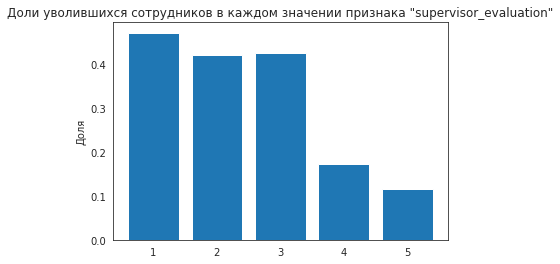

In [140]:
share(train_1, 'supervisor_evaluation')  

Большинство уволившихся сотрудников получили оценка '3' по итогам прошлого года. Их доля достигает 40% среди получивших оценку 1,2,3. Среди получивших оценки 4 и 5 доля уволившихся сильно меньше.

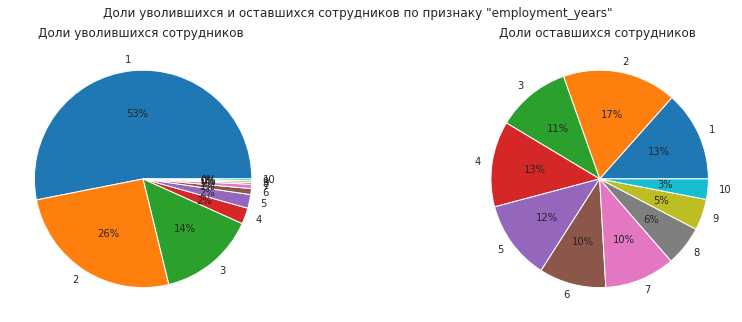

In [141]:
pie(train_1, 'employment_years')

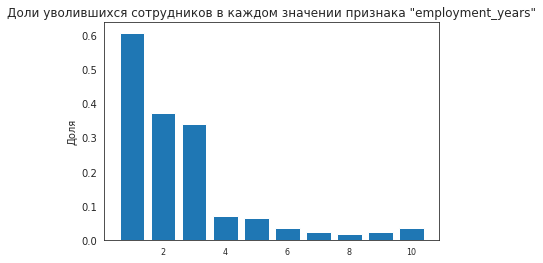

In [142]:
share(train_1, 'employment_years')  
plt.xticks(fontsize=8);

У большинства уволившихся сотрудников опыт 1-2 года в компании. Самая большая доля уволившихся - среди сотрудников, проработавших 1,2 или 3 года.

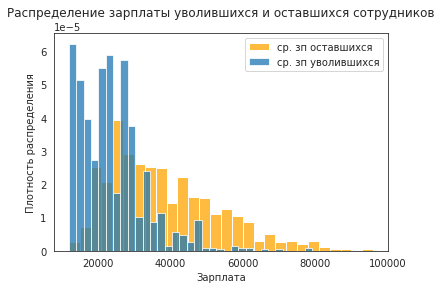

In [143]:
sns.histplot(no_quit_1['salary'], stat='density', common_norm=False, color='orange');
#plt.vlines(x=no_quit_1['salary'].mean(), colors='red', ymin=0, ymax=6);
plt.legend('уволившиеся');
sns.histplot(quit_1['salary'], stat='density', common_norm=False);
#plt.vlines(x=quit_1['salary'].mean(), colors='red', ymin=0, ymax=6, linestyles='--');
plt.title('Распределение зарплаты уволившихся и оставшихся сотрудников');
plt.xlabel('Зарплата');
plt.ylabel('Плотность распределения');
plt.legend(('ср. зп оставшихся', 'ср. зп уволившихся', 'зп оставшихся', 'зп уволившихся'));

У уволившихся сотрудников была достаточно низкая средняя зарплата - около 25,000 по сравнению с оставшимися - около 38,0000.

Добавим признак 'job_satisfaction_rate' из первой задачи в тестовую выборку, чтобы проверить, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. 

In [144]:
test_2_full=test_1_full.merge(test, on='id')
test_2_full

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.72
2,467458,sales,middle,low,5,no,no,4,19200,no,0.64
3,418655,sales,middle,low,6,no,no,4,19200,no,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.75
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,yes,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,yes,0.14
1997,305653,technology,junior,low,1,no,no,3,14400,yes,0.11
1998,160233,technology,middle,low,8,no,no,1,32400,no,0.43


In [145]:
quit_2 = test_2_full.query('quit == "yes"')
no_quit_2 = test_2_full.query('quit == "no"')

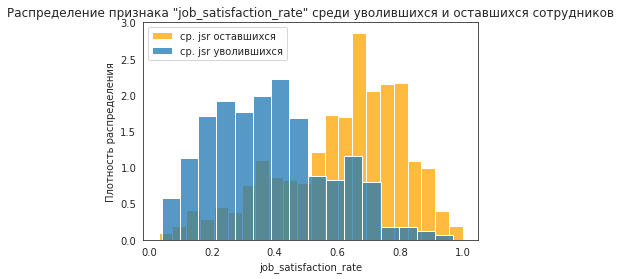

In [146]:
sns.histplot(no_quit_2['job_satisfaction_rate'], stat='density', common_norm=False, color='orange');
#plt.vlines(x=no_quit_2['job_satisfaction_rate'].median(), colors='red', ymin=0, ymax=400);
plt.title('Распределение признака "job_satisfaction_rate" среди уволившихся и оставшихся сотрудников');
plt.legend('уволившиеся');
sns.histplot(quit_2['job_satisfaction_rate'], stat='density', common_norm=False);
#plt.vlines(x=quit_2['job_satisfaction_rate'].median(), colors='red', ymin=0, ymax=400, linestyles='--');
plt.title('Распределение признака "job_satisfaction_rate" среди уволившихся и оставшихся сотрудников');
plt.xlabel('job_satisfaction_rate');
plt.ylabel('Плотность распределения');
plt.legend(('ср. jsr оставшихся', 'ср. jsr уволившихся', 'jsr оставшихся', 'jsr уволившихся'));



Действительно, уровень удовлетворенности среди уволившихся сотрудников значительно уступает таковому у оставшихся. Есть основание полагать, что данные признаки взаимосвязаны!

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

Итак, по итогам исследоваельского анализа все параметры тренировочной выбокрки совпадают с таковыми в задаче 1.
На основе анализа можно сделать вывод, что уволившиеся сотрудники:
- чуть чаще увольнялись из отделов Technoloqy, Sales и Purchasing и чуть реже из Marketing и HR, распределение уволившихся сотрудников по отделам в целом совпадает с  распределением оствшихся сотрудников по отделам
- в основном у них был уровень Junior, из таковых уволилось около 50%
- низкий или средний уровень загруженности, наибольший % уволившихся среди сотрудников - среди сотрудников низким уровнем загруженности
- опыт 1-2 года в компании, cамая большая доля уволившихся - среди сотрудников, проработавших 1,2 или 3 года.
- оценка '3' по итогам прошлого года, их доля достигает 40% среди получивших оценку 1,2,3. Среди получивших оценки 4 и 5 доля уволившихся сильно меньше.
- несколько большая доля last_year_violations по сравнению с оставшимися, среди отличившихся доля уволившихся достигает 40%.
- практически никто из них не был промотирован в прошлом году,  их доля среди непромотированных гораздо больше, чем среди промотированных
- у них была достаточно низкая средняя зарплата - около 25,000 по сравнению с оставшимися - около 38,0000.
- уровень удовлетворенности среди уволившихся сотрудников значительно уступает таковому у оставшихся

### Добавление нового входного признака

Предскажем целевой признак job_satisfaction_rate для тренировочной и тестовой выборок.

In [147]:
X_test_1 = train_1.drop(['quit', 'id'], axis=1)
X_test_2 = test_2_full.drop(['quit', 'id'], axis=1)

In [148]:
y_test_pred_1 = randomized_search.predict(X_test_1)
y_test_pred_1

array([0.62666667, 0.82888889, 0.335     , ..., 0.54875   , 0.502     ,
       0.47142857])

In [149]:
y_test_pred_2 = randomized_search.predict(X_test_2)
y_test_pred_2 

array([0.8495    , 0.664     , 0.69181818, ..., 0.17      , 0.51857143,
       0.56571429])

Добавим новуюю колонку в тренировочный датасет.

In [150]:
train_1['job_satisfaction_rate']=y_test_pred_1
train_1

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.626667
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.828889
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.335000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.334286
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.794667
...,...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no,0.528571
3996,672059,sales,middle,high,9,no,no,4,52800,no,0.862222
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.548750
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no,0.502000


### Подготовка данных

Используем пайплайны для кодирования категориальных и масштабирования количественных признаков.

In [151]:
X_train = train_1.drop(['id','quit'], axis=1)
y_train = train_1['quit']    
X_test = test_2_full.drop(['quit', 'id'], axis=1)
X_test['job_satisfaction_rate'] = y_test_pred_2 
y_test = test_2_full['quit']

In [152]:
ohe_columns = ['dept']
num_columns=['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']

In [153]:
ohe_pipe = Pipeline(
    [
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

In [154]:
ord_pipe = Pipeline(
    [
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['yes', 'no']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ])


In [155]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [156]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()    
) 
X_train_p.head(10)

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ord__level,ord__workload,ord__last_year_promo,ord__last_year_violations,num__employment_years,num__supervisor_evaluation,num__salary,num__job_satisfaction_rate
0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,-0.669477,0.523197,1.332905,0.415025
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.669477,0.523197,-0.409610,1.353920
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.510912,-2.465078,0.224032,-0.939150
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.669477,-0.472895,-0.647225,-0.942466
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.669477,1.519289,-0.568020,1.195030
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.062941,-0.472895,-1.043251,-1.976061
6,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.691301,-1.468986,0.699263,-0.799863
7,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.117449,1.519289,-0.964046,-0.343313
8,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.297838,0.523197,-0.568020,1.243006
9,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,-0.669477,-0.472895,0.778468,-1.187876


In [157]:
X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()    
) 
X_test_p.head(10)

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ord__level,ord__workload,ord__last_year_promo,ord__last_year_violations,num__employment_years,num__supervisor_evaluation,num__salary,num__job_satisfaction_rate
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.669477,1.519289,-0.330404,1.449615
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.062941,0.523197,-0.251199,0.588359
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.510912,0.523197,-0.964046,0.717516
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.904375,0.523197,-0.964046,0.717516
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.510912,1.519289,0.461647,1.289435
5,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.904375,-0.472895,0.540853,0.236593
6,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-0.276014,-0.472895,-0.488815,-0.962364
7,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,2.084764,0.523197,1.016084,0.560502
8,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,-0.276014,0.523197,1.887341,0.001034
9,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.062941,-0.472895,-0.488815,-1.632266


In [158]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_train

array([0, 0, 0, ..., 1, 0, 1])

In [159]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### Обучение модели

Обучим следующие модели: KNeighborsClassifier(), DecisionTreeClassifier(), SVC(), LogisticRegression() и подберем для них гиперпараметры в пайплайнах.

In [160]:
param_distributions = [
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],  
        
    },
   
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],  
        
    },
    
    {
        'models': [SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 10],
        'models__gamma': [0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        

    },
   
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        
    }
] 

In [161]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [162]:
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', round(randomized_search.best_score_,2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                    

In [163]:
y_test_pred = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_pred),2)}') 

Метрика ROC-AUC на тестовой выборке: 0.92


In [164]:
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)
dummy_model_preds = dummy_model.predict_proba(X_test)[:,1]
dummy_roc_auc = roc_auc_score(y_test, dummy_model_preds)
print('dummy model ROC-AUC =', round(dummy_roc_auc, 2))



dummy model ROC-AUC = 0.5


PermutationExplainer explainer: 2001it [01:39, 18.92it/s]                          


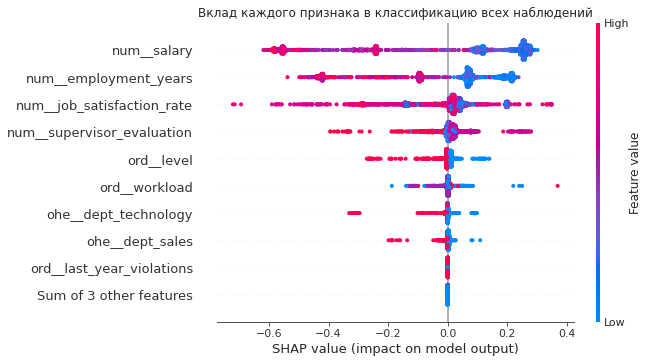

In [165]:
best_model=randomized_search.best_estimator_.named_steps['models']
explainer = shap.Explainer(best_model.predict, X_test_p)
shap_values = explainer(X_test_p)
plt.title('Вклад каждого признака в классификацию всех наблюдений');
shap.plots.beeswarm(shap_values) ;


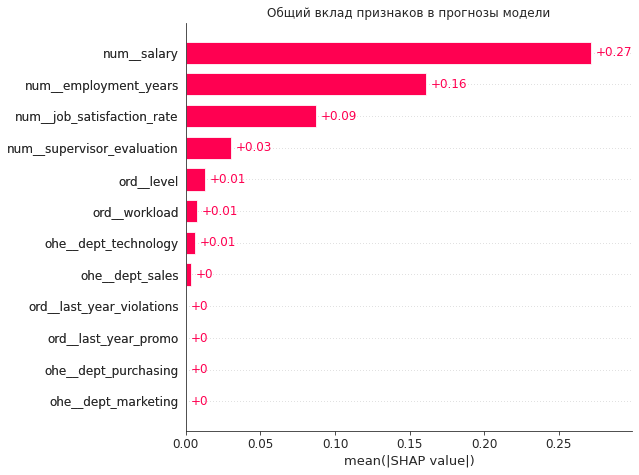

In [166]:
shap.plots.bar(shap_values, max_display=17, show=False);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.title('Общий вклад признаков в прогнозы модели');

Чем выше значения признаков (в порядке убывания значимости признака): salary, employment_years, job_satisfaction_rate, supervisor_evaluation, level, workload - тем выше вероятность принадлежности к классу 0: "остался работать в компании". 

Незначимы для модели следующие признаки: last_year_violations, last_year_promo, dept.

### Выводы

Лучшей моделью оказалась: DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=3, random_state=42)
Метрика ROC-AUC лучшей модели на кросс-валидации: 0.93
Метрика ROC-AUC на тестовой выборке: 0.92
Самые важные признаки (в порядке убывания): job_satisfaction_rate, level,  employment_years, salary, workload, last_year_violations, остальные признаки незначимые.

# Общий вывод

1) Задачи проекта: в данном проекте по HR-аналитике необходимо было предложить заказчику, как избежать финансовых потерь и оттока сотрудников. Было поставлено 2 задачи: 1)Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, тк удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник. 2) Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Заказчиком предоставлены данные по сотрудникам, содержащие такие параметры, как: отдел, уровень должности сотрудника, загруженность, количество лет в компании, зарплата, оценка качества работы, было ли повышение за последний год, нарушался ли трудовой договор за последний год, уровень удовлетворенности работой, ушел/остался в компании.

В рамках проекта проделаны следующие этапы: -загрузка данных -предобработка данных -исследовательский анализ данных -обучение моделей -сделан общий вывод и даны рекомендации заказчику

2) По итогам предобработки данных были выявлены пропуски в датасетах train_job_satisfaction_rate и test_features - во входных признаках 'dept' и 'level', а также в датасете test_target_job_satisfaction_rate - пробелы в признаках 'dept' и 'workload'. Оба вида пропускв были заполнены в паплайнах. Явных или неявных дубликатов вывлено не было.

3) По итогам исследовательского анализ данных:
Средний балл 3,5 на обоих выборках, чаще всего сотрудникам ставили оценки "3" и "4".
Больше всего сотудников проработало в компании 1 или 2 года.
Средняя зарплата сотрудников - около 34,000, медианная - 30,000. Минимум - 12,000, мксимум - 98,000, присутствует много выбросов в бОльшую сторону.
Средний уровень удовлетворенности сотрудников - около 0,52, выбросов нет.
Больше всего сотрудников работает в отделе Sales, затем следуют Technology, Purchasing, Marketing и меньше всего в HR.
Больше всего сотрудников имеют уровнь "junior", чуть меньше "middle" и меньшинство "sinior".
Большинство сотрудников имеет средний уровень загруженности.
Очень малая доля сотрудников получили промоушен в прошлом году.
Около 750 сотрудников нарушили договор в прошлом году. Мультиколлинеарность(значение коэффициента корреляции более 0.9 по модулю) между признаками не наблюдается.

Мультиколлинеарность (значение коэффициента корреляции более 0.9 по модулю) между признаками не наблюдается.
Можно отметить высокий уровень корреляции между целевым признаком "job_satisfaction_rate" и входным признаком  "supervisor_evaluation", заметный уровень с "last_year_violations" и а также умереннуую корреляцию с "employment_years".
Также можно отметить заметный уровень корреляции между целевым признаком "quit" и входным признаком  "employment_years" и "salary", умеренный уровень с "workload".
А также можно отметить высокую корреляцию между  входными признаками "salary" и "workload", "salary" и "level" и умеренную между "salary" и "employment_years"; заметную между "level" и "employment_years"; умеренную - между "level" и "workload". 


4) В первой задаче были обучены следующие модели: LinearRegression(), DecisionTreeRegressor(random_state=RANDOM_STATE) с гиперпараметрами max_depth, min_samples_leaf, min_samples_split.
Лучшей моделью для решения первой задачи оказалось Дерево решений: DecisionTreeRegressor(max_depth=14, min_samples_leaf=5, min_samples_split=5, random_state=42)
Метрика SMAPE лучшей модели на кросс-валидации: 14.89
Метрика SMAPE лучшей модели на тестовой выборке: 13.64.
Модель DecisionTreeRegressor() сработала лучше, чем LinearRegression(), видимо из-за того, что присутствуют  нелинейные зависимости между целевым и входными признаками.
Самые важные признаки (в порядке убывания): supervisor_evaluation,  salary, employment_years, last_year_violations, level, workload, остальные признаки менее значимые. 

5) Портрет уволившегося сотрудника.
На основе анализа можно сделать вывод, что уволившиеся сотрудники:
- чуть чаще увольнялись из отделов Technoloqy, на одном уровне из отделов Sales, Purchasing, Marketing и чуть реже HR, распределение уволившихся сотрудников по отделам в целом совпадает с  распределением оствшихся сотрудников по отделам
- в основном у них был уровень Junior, из таковых уволилось около 50%
- низкий или средний уровень загруженности, наибольший % уволившихся среди сотрудников - среди сотрудников низким уровнем загруженности
- опыт 1-2 года в компании, cамая большая доля уволившихся - среди сотрудников, проработавших 1,2 или 3 года.
- оценка '3' по итогам прошлого года, их доля достигает 40% среди получивших оценку 1,2,3. Среди получивших оценки 4 и 5 доля уволившихся сильно меньше.
- несколько большая доля last_year_violations по сравнению с оставшимися, среди отличившихся доля уволившихся достигает 40%.
- практически никто из них не был промотирован в прошлом году,  их доля среди непромотированных гораздо больше, чем среди промотированных
- у них была достаточно низкая средняя зарплата - около 25,000 по сравнению с оставшимися - около 38,0000.
- уровень удовлетворенности среди уволившихся сотрудников значительно уступает таковому у оставшихся. 

6) Во второй задаче были обучены следующие модели: KNeighborsClassifier() с гиперпараметраом n_neighbors, DecisionTreeClassifier(random_state=RANDOM_STATE) с гипепараметрами max_depth, min_samples_leaf, min_samples_split, SVC(SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE) с гиперпараметрами С и gamma, LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1') с гиперпараметром С.

Лучшей моделью оказалась: DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=3, random_state=42)
Метрика ROC-AUC лучшей модели на кросс-валидации: 0.93
Метрика ROC-AUC на тестовой выборке: 0.92
ем выше значения признаков (в порядке убывания значимости признака): salary, employment_years, job_satisfaction_rate, supervisor_evaluation, level, workload - тем выше вероятность принадлежности к классу 0: "остался работать в компании".
Незначимы для модели следующие признаки: last_year_violations, last_year_promo, dept.

7) Предложения для бизнеса: 
Для контроля значений признака job_satisfaction_rate, который как мы выяснили, непосредственно влияет и на отток сотрудников, бизнесу необходимо обратить внимание на следующие параметры: supervisor_evaluation,  salary, employment_years, last_year_violations, level, workload. 
Для того, чтобы снизить непосредственно отток сотрудников, необходимо контролировать  те же самые параметры: job_satisfaction_rate, level, employment_years, salary, workload, last_year_violations.
